# Turing Target Practice

## Model

In [9]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [10]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using FFTW
using PyPlot

using Revise
using MCHMC

In [11]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [12]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [13]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [14]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [19]:
target = TuringTarget(stat_model);

In [20]:
mchmc = Sampler(0.0, sqrt(target.d), varE_wanted=1.0)

L = 1.4142135623730951, eps = 0.0


Sampler(Settings(Random.MersenneTwister(0), 1.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 1.4142135623730951, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [21]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

Tuning eps
eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 17.850899765100145
eps: 0.125 --> VarE: 27.730755340294895
eps: 0.0625 --> VarE: 5.03227359450665
eps: 0.03125 --> VarE: 1.6542787771749885
eps: 0.015625 --> VarE: 0.7588887209014545


Row,Ω,E,logp
,Any,Any,Any
1,"[0.372388, 0.934392]",-1.82493,5.63663
2,"[0.384991, 0.943628]",-3.062,7.45282
3,"[0.387562, 0.928216]",4.99355,9.6366
4,"[0.380396, 0.914331]",6.29287,11.5812
5,"[0.372165, 0.90105]",5.58475,13.2786
6,"[0.363899, 0.887791]",4.84852,14.7335
7,"[0.355034, 0.874924]",4.12431,15.9473
8,"[0.345697, 0.862395]",3.40443,16.9234
9,"[0.335666, 0.850415]",2.6918,17.6618


In [39]:
ifft(conj(fft(mapreduce(permutedims, vcat, samples_mchmc.Ω))))

10000×2 Matrix{ComplexF64}:
 0.372388+1.61948e-17im  0.934392+3.31679e-19im
 0.182951-3.94411e-18im  0.836232+1.38772e-17im
 0.168299+3.12155e-18im  0.841662-1.35364e-17im
  0.16954-2.93833e-17im  0.857237-6.01472e-18im
   0.1805-1.78036e-17im  0.868374+9.98343e-18im
 0.194166-1.30573e-17im  0.875948+5.39319e-18im
 0.208862+3.29218e-18im  0.881257-1.19498e-18im
 0.223747-1.10414e-17im  0.886006-1.90444e-17im
  0.23921-2.01746e-17im  0.883762-8.37406e-18im
 0.253514-1.32361e-17im  0.877474+1.2468e-17im
 0.261866-1.3846e-17im   0.864268+8.69555e-18im
 0.264114+1.17494e-17im  0.848806+1.20855e-17im
 0.261411-3.36747e-18im  0.833416-6.62047e-18im
         ⋮               
 0.288714+1.44484e-17im  0.809692-3.88248e-18im
 0.301818+1.15432e-17im  0.818203-9.33811e-18im
 0.313268+7.51381e-19im  0.828835-8.58902e-18im
 0.325517-1.37914e-17im  0.838536+6.16962e-18im
 0.335666-1.63485e-17im  0.850415-6.9356e-19im
 0.345697+1.5799e-17im   0.862395+5.1656e-18im
 0.355034+1.89259e-17im  0.874924-2.7

In [24]:
fft(samples_mchmc.Ω)

LoadError: MethodError: no method matching plan_fft(::Vector{Any}, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  plan_fft([91m::StridedArray{T, N}[39m, ::Any; flags, timelimit, num_threads) where {T<:Union{ComplexF32, ComplexF64}, N}
[0m[90m   @[39m [32mFFTW[39m [90m~/.julia/packages/FFTW/sfy1o/src/[39m[90m[4mfft.jl:709[24m[39m
[0m  plan_fft([91m::AbstractArray{<:Real}[39m, ::Any; kws...)
[0m[90m   @[39m [36mAbstractFFTs[39m [90m~/.julia/packages/AbstractFFTs/Wg2Yf/src/[39m[90m[4mdefinitions.jl:211[24m[39m
[0m  plan_fft([91m::AbstractArray{<:Complex{<:Union{Integer, Rational}}}[39m, ::Any; kws...)
[0m[90m   @[39m [36mAbstractFFTs[39m [90m~/.julia/packages/AbstractFFTs/Wg2Yf/src/[39m[90m[4mdefinitions.jl:213[24m[39m
[0m  ...


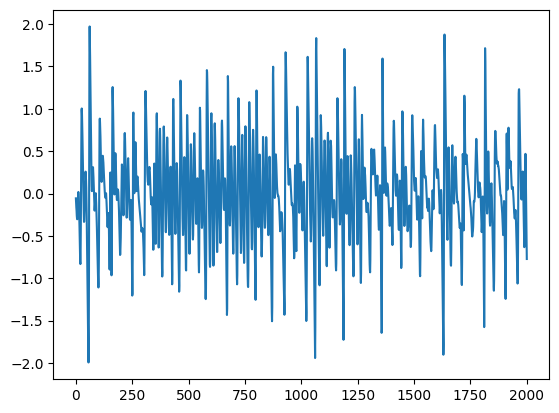

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fea5bc130a0>

In [339]:
plt.plot(samples_mchmc.E[8000:end])

In [346]:
length(samples_mchmc.Ω)

10000

In [340]:
mean(samples_mchmc.E[8000:end])

┌ Error: Failed to revise /home/jaimerz/PhD/MCHMC.jl/src/tuning.jl
│   exception =
│    LoadError: "missing comma or ) in argument list"
│    Stacktrace:
│     [1] parse_source!(mod_exprs_sigs::OrderedCollections.OrderedDict{Module, OrderedCollections.OrderedDict{Revise.RelocatableExpr, Union{Nothing, Vector{Any}}}}, src::String, filename::String, mod::Module; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Revise ~/.julia/packages/Revise/VRgaS/src/parsing.jl:45
│    in expression starting at /home/jaimerz/PhD/MCHMC.jl/src/tuning.jl:21
└ @ Revise ~/.julia/packages/Revise/VRgaS/src/packagedef.jl:716
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/jaimerz/PhD/MCHMC.jl/src/tuning.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yello

-0.0017679275567858018

In [341]:
std(samples_mchmc.E[8000:end])^2/target.d

0.1629104933574212

In [342]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

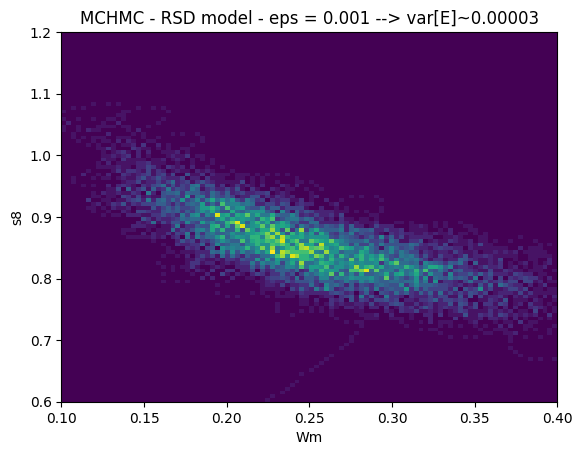

In [343]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## NUTS

In [102]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.43 seconds
Compute duration  = 2.43 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2516    0.0598     0.0006    0.0012   2773.9550    0.9999    ⋯
          σ8    0.8527    0.0543     0.0005    0.0011   2590.8094    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [103]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

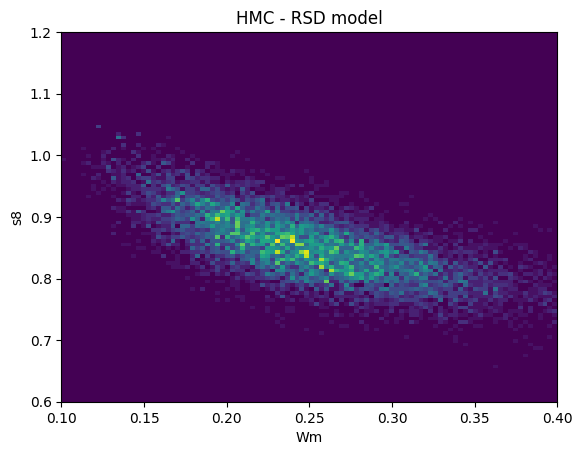

In [104]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");